In [1]:
from IPython.display import clear_output
!pip install vit_keras
!pip install tensorflow-addons

clear_output()

In [3]:
import warnings
import logging
import os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from vit_keras import vit


IMG_SIZE = 224, 224
BATCH_SIZE = 32
SEED = 999
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connecting TPU and creating strategy and the model

resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

stg = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

ValueError: Please provide a TPU Name to connect to.

Cargar una parte del dataset de entrenamiento

(-0.5, 511.5, 511.5, -0.5)

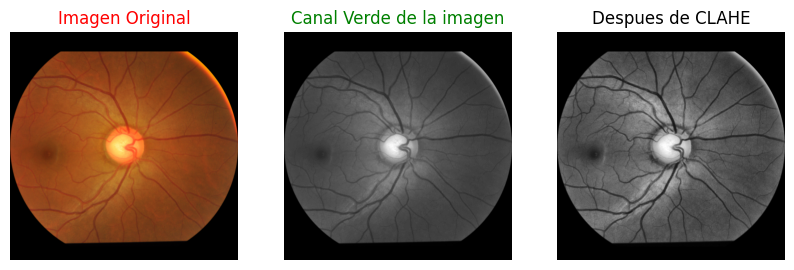

In [ ]:
normal_image = cv2.imread('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test/0/BEH-180.png')
normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)

green_channnel = normal_image[:,::,1] #splitting Green channel from a RGB image

clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
final_img = clahe_op.apply(green_channnel)


fig, axs = plt.subplots(1,3, figsize = (10,5), dpi = 100)

axs[0].imshow(normal_image)
axs[0].set_title('Imagen Original', color = 'red')
axs[0].axis('off')

axs[1].imshow(green_channnel, cmap = 'gray')
axs[1].set_title('Canal Verde de la imagen', color ='green')
axs[1].axis('off')

axs[2].imshow(final_img, cmap = 'gray')
axs[2].set_title('Despues de CLAHE')
axs[2].axis('off')

Creamos nuevas carpetas con estas modificaciones de las imagenes

In [ ]:
import os
base_path = '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/'

# Crear carpetas para el conjunto de entrenamiento
os.mkdir(os.path.join(base_path, 'train_converted_images'))
os.mkdir(os.path.join(base_path, 'train_converted_images', '0'))
os.mkdir(os.path.join(base_path, 'train_converted_images', '1'))

# Crear carpetas para el conjunto de validación
os.mkdir(os.path.join(base_path, 'val_converted_images'))
os.mkdir(os.path.join(base_path, 'val_converted_images', '0'))
os.mkdir(os.path.join(base_path, 'val_converted_images', '1'))

# Crear carpetas para el conjunto de prueba
os.mkdir(os.path.join(base_path, 'test_converted_images'))
os.mkdir(os.path.join(base_path, 'test_converted_images', '0'))
os.mkdir(os.path.join(base_path, 'test_converted_images', '1'))

FileExistsError: [Errno 17] File exists: '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images'

Aplicamos la máscara a las imágenesyh creamos el nuevo dataset

In [ ]:
# A normal image > Green channel > Histogram Equalization

def image_cvt_histeq(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        #BGR images, I want to split the green channel
        img = cv2.imread(os.path.join(main_path, i))[:,::,1]
        clahe_op = cv2.createCLAHE(clipLimit= 2) # histogram equalization
        final_img = clahe_op.apply(img)

        cv2.imwrite(os.path.join(target_path, i), final_img)

In [ ]:
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train/0', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/0')
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train/1', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/1')

image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val/0', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/0')
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val/1', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/1')

image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test/0', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/0')
image_cvt_histeq('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test/1', '/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/1')

In [13]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


train_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/0')
train_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/train_converted_images/1')

val_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/0')
val_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/val_converted_images/1')

test_data_0 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/0')
test_data_1 = create_images_list('/content/drive/My Drive/Tesis/Proyectos2/BD_GlaucomaTorch/test_converted_images/1')


# look-up table
classes = {0: 'non-glaucoma', 1: 'glaucoma'}


train_df = pd.concat([pd.DataFrame({ 'image' : train_data_0, 'label': 0 }),
                      pd.DataFrame({ 'image' : train_data_1, 'label': 1 }) ], ignore_index = True)


val_df = pd.concat([pd.DataFrame({ 'image' : val_data_0, 'label': 0 }),
                    pd.DataFrame({ 'image' : val_data_1, 'label': 1 }) ], ignore_index = True)


test_df = pd.concat([pd.DataFrame({ 'image' : test_data_0, 'label': 0 }),
                     pd.DataFrame({ 'image' : test_data_1, 'label': 1 }) ], ignore_index = True)


train_df = shuffle(train_df, random_state = SEED).reset_index(drop = True)
val_df = shuffle(val_df, random_state = SEED).reset_index(drop = True)
test_df = shuffle(test_df, random_state = SEED).reset_index(drop = True)

print("train images -> ", train_df.shape[0])
print("val images -> ", val_df.shape[0])
print("test images -> ", test_df.shape[0])

train images ->  8631
val images ->  5767
test images ->  2250


Redimensinoar y Normalizar

In [14]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.3, seed = SEED)

    return img, label

# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_df['image'], train_df['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


val_loader = tf.data.Dataset.from_tensor_slices((val_df['image'], val_df['label']))
val_dataset = (val_loader
               .map(img_preprocessing, num_parallel_calls = AUTO)
               .batch(BATCH_SIZE)
               .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['image'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

Modelo ViT

In [11]:
from vit_keras import vit

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 2)

inp = Input(shape = (*IMG_SIZE, 3))
vit = vit_model(inp)
X = Flatten()(vit)


X = BatchNormalization()(X)

X = Dense(256, activation='gelu', kernel_regularizer=l2(0.01))(X)
X = Dense(64, activation='gelu', kernel_regularizer=l2(0.01))(X)
X = Dense(32, activation='gelu', kernel_regularizer=l2(0.01))(X)
out = Dense(2, activation='softmax')(X)

model = Model(inputs = inp, outputs = out)
model.summary()

model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001, weight_decay = 0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc'] )

my_callback = [EarlyStopping( monitor = "val_loss", min_delta = 0.001, patience = 5)]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 256)               196864    
                                                           

In [15]:
# Training model

hist = model.fit(train_dataset, epochs = 2, batch_size = BATCH_SIZE, validation_data = val_dataset, callbacks = my_callback)

Epoch 1/2
270/270 [==============================] - 3677s 13s/step - loss: 0.5152 - acc: 0.7516 - val_loss: 0.9364 - val_acc: 0.5802
Epoch 2/2
270/270 [==============================] - 435s 2s/step - loss: 0.4093 - acc: 0.8213 - val_loss: 0.7391 - val_acc: 0.6933


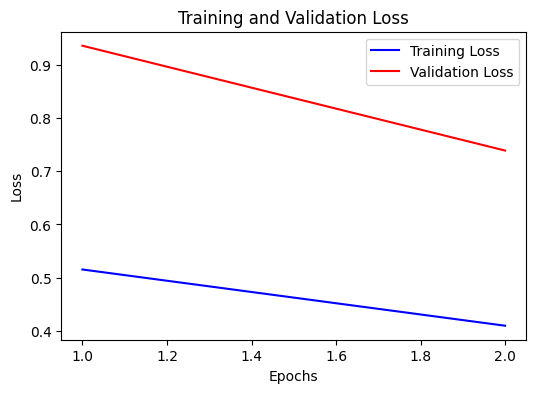

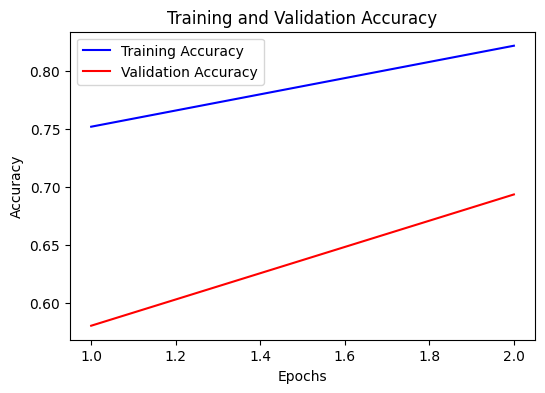

In [16]:
# Obtener historial de entrenamiento
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(1, len(train_loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar el accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print('ViT model results')
print('--'*50)
val_eval_vit = model.evaluate(val_dataset)
print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
print('--'*50)
test_eval_vit = model.evaluate(test_dataset)
print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Evaluación en el conjunto de validación
val_loss, val_acc = model.evaluate(val_dataset)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Predicciones en el conjunto de validación
val_predictions = model.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Predicciones en el conjunto de prueba
test_predictions = model.predict(test_dataset)
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Calcular métricas
val_accuracy = accuracy_score(val_labels, np.argmax(val_predictions, axis=1))
val_precision = precision_score(val_labels, np.argmax(val_predictions, axis=1))
val_recall = recall_score(val_labels, np.argmax(val_predictions, axis=1))
val_f1 = f1_score(val_labels, np.argmax(val_predictions, axis=1))
val_conf_matrix = confusion_matrix(val_labels, np.argmax(val_predictions, axis=1))

test_accuracy = accuracy_score(test_labels, np.argmax(test_predictions, axis=1))
test_precision = precision_score(test_labels, np.argmax(test_predictions, axis=1))
test_recall = recall_score(test_labels, np.argmax(test_predictions, axis=1))
test_f1 = f1_score(test_labels, np.argmax(test_predictions, axis=1))
test_conf_matrix = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))

# Imprimir métricas
print('--'*50)
print("Validacion")
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)
print("Validation Confusion Matrix:\n", val_conf_matrix)

print('--'*50)
print("Prueba")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_conf_matrix)

181/181 [==============================] - 80s 439ms/step - loss: 0.7391 - acc: 0.6933
Validation Loss: 0.7390544414520264
Validation Accuracy: 0.6932547092437744
71/71 [==============================] - 536s 8s/step - loss: 0.9445 - acc: 0.6151
Test Loss: 0.9444708228111267
Test Accuracy: 0.6151111125946045
71/71 [==============================] - 30s 426ms/step
----------------------------------------------------------------------------------------------------
Validacion
Validation Accuracy: 0.6932547251603953
Validation Precision: 0.5584787705131544
Validation Recall: 0.9666366095581606
Validation F1 Score: 0.7079412250288922
Validation Confusion Matrix:
 [[1854 1695]
 [  74 2144]]
----------------------------------------------------------------------------------------------------
Prueba
Test Accuracy: 0.6151111111111112
Test Precision: 0.362962962962963
Test Recall: 0.9879032258064516
Test F1 Score: 0.5308775731310942
Test Confusion Matrix:
 [[894 860]
 [  6 490]]


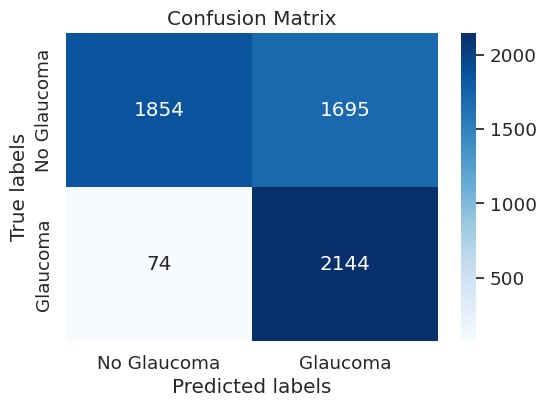

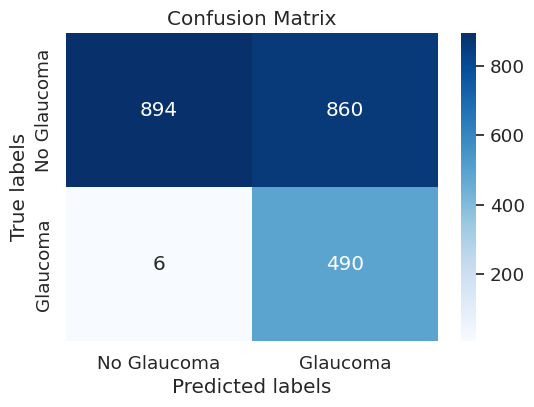

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Visualizar la matriz de confusión en el conjunto de validación
plot_confusion_matrix(val_conf_matrix, labels=['No Glaucoma', 'Glaucoma'])

# Visualizar la matriz de confusión en el conjunto de prueba
plot_confusion_matrix(test_conf_matrix, labels=['No Glaucoma', 'Glaucoma'])


Otro modelo Transformer

In [ ]:
from swintransformer import SwinTransformer

model = SwinTransformer('swin_tiny_224', num_classes=1000, include_top=True, pretrained=False)

No se si funciona es un modelo propio

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model

# Definir la arquitectura de la capa de parches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Definir el modelo Vision Transformer
def create_vit_model(image_size, patch_size, num_classes, num_layers, d_model, num_heads, mlp_dim, channels=3):
    inputs = layers.Input(shape=(image_size, image_size, channels))
    # Dividir la imagen en parches
    patches = Patches(patch_size)(inputs)
    # Embeber los parches
    x = layers.Embedding(input_dim=patches.shape[1], output_dim=d_model)(patches)
    # Añadir codificación posicional
    positions = tf.range(start=0, limit=patches.shape[1], delta=1)
    position_embeddings = layers.Embedding(input_dim=patches.shape[1], output_dim=d_model)(positions)
    x += position_embeddings
    # Aplicar capas Transformer
    for _ in range(num_layers):
        x = tfa.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=0.1)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x_ffn = layers.Dense(units=mlp_dim, activation='relu')(x)
        x_ffn = layers.Dropout(0.1)(x_ffn)
        x_ffn = layers.Dense(units=d_model)(x_ffn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + x_ffn)
    # Tomar la salida del primer token como representación de toda la imagen
    cls_token = x[:, 0, :]
    # Añadir una capa de salida para la clasificación
    outputs = layers.Dense(num_classes, activation='softmax')(cls_token)
    # Construir el modelo
    model = Model(inputs, outputs)
    return model

# Parámetros del modelo
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 1000  # Número de clases en tu conjunto de datos
NUM_LAYERS = 12
D_MODEL = 768
NUM_HEADS = 12
MLP_DIM = 3072

# Crear el modelo ViT
vit_model = create_vit_model(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM
)

# Compilar el modelo
vit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
vit_model.summary()
